In [1]:
import pandas as pd
import numpy as np
from kan import KAN
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

np.random.seed(122)

c:\Users\matti\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('preprocessed_data.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,493,494,495,496,497,498,499,dataset,target1,target2
0,0.272274,-0.009553,-0.111540,-0.002884,-0.008870,0.009169,0.047475,0.079900,-0.053873,-0.002341,...,0.002970,0.019301,0.003766,-0.006881,0.026081,0.005574,0.022611,train,0.0,1.0
1,0.078526,0.012641,0.047646,-0.005053,0.002490,-0.067008,-0.019146,0.005979,0.031569,-0.023099,...,-0.012917,-0.028911,0.029198,0.012052,0.010839,0.017262,-0.009858,train,1.0,0.0
2,0.274658,-0.104397,-0.109082,-0.050277,-0.022193,-0.015294,-0.008372,0.020402,-0.026648,0.028496,...,-0.008156,0.036260,-0.026132,0.021999,0.005494,-0.008337,0.017657,train,0.0,1.0
3,0.253039,-0.063613,0.058053,0.049315,-0.031136,0.008439,0.029840,-0.078593,0.050998,0.029432,...,-0.003836,-0.025037,-0.052235,0.002569,0.005448,0.043514,0.059938,train,1.0,0.0
4,0.182117,0.005948,0.010821,-0.090231,0.030875,0.085763,0.022347,-0.003929,-0.014739,-0.081541,...,-0.017357,0.024389,0.023063,0.000151,-0.011612,0.009606,-0.012669,train,1.0,0.0


In [3]:
X_train = df[df['dataset'] == 'train'].drop(columns=['dataset', 'target1', 'target2'])
print(f"X Train shape: {np.shape(X_train)}")

y_train = df[df['dataset'] == 'train']['target1']
print(f"y Train shape: {np.shape(y_train)}")

X_val= df[df['dataset'] == 'val'].drop(columns=['dataset', 'target1', 'target2'])
print(f"X val shape: {np.shape(X_val)}")

y_val = df[df['dataset'] == 'val']['target1']
print(f"y val shape: {np.shape(y_val)}")

X_test = df[df['dataset'] == 'test'].drop(columns=['dataset', 'target1', 'target2'])
print(f"X test shape: {np.shape(X_test)}")

y_test = df[df['dataset'] == 'test']['target1']
print(f"y test shape: {np.shape(y_test)}")


X Train shape: (1600, 500)
y Train shape: (1600,)
X val shape: (200, 500)
y val shape: (200,)
X test shape: (200, 500)
y test shape: (200,)


In [4]:
model = KAN(width=[500, 2], grid = 3, k=3, seed = 2024)

y_train = y_train.astype(np.int64)
y_val = y_val.astype(np.int64)
y_test = y_test.astype(np.int64)

dataset = {}
dataset['train_input'] = torch.from_numpy(X_train.values)
dataset['train_label'] = torch.from_numpy(y_train.values).long()

dataset['val_input'] = torch.from_numpy(X_val.values)
dataset['val_label'] = torch.from_numpy(y_val.values).long()

dataset['test_input'] = torch.from_numpy(X_test.values)
dataset['test_label'] = torch.from_numpy(y_test.values).long()

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim = 1) == dataset['train_label']).float())

def val_acc():
    return torch.mean((torch.argmax(model(dataset['val_input']), dim = 1) == dataset['val_label']).float())


In [5]:
results = model.train(dataset, opt="LBFGS", steps=20, metrics =(train_acc, val_acc),loss_fn=torch.nn.CrossEntropyLoss(), lamb = 0.001)

description:   0%|                                                           | 0/20 [00:05<?, ?it/s]


KeyboardInterrupt: 

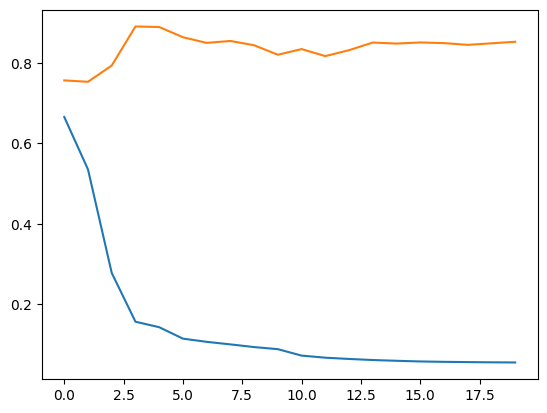

In [ ]:
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])

KeyError: 'val_acc'

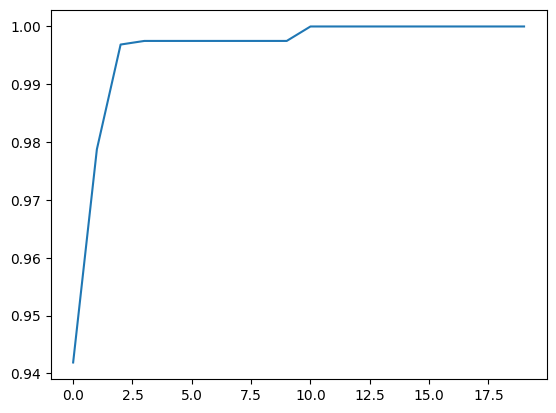

In [56]:
plt.plot(results['train_acc'])
plt.plot(results['test_acc'])

In [29]:
results['train_acc'][-1]

1.0

In [30]:
results['val_acc'][-1]

0.7450000047683716

In [34]:
torch.argmax(model(dataset['train_input']), dim = 1)

tensor([0, 1, 0,  ..., 0, 0, 1])

In [35]:
dataset['train_label']

tensor([0, 1, 0,  ..., 0, 0, 1])

In [9]:
def predictions(model, X):
    return torch.argmax(model(X), dim = 1)

def extract_results(pred, labels):
    # Ensure the inputs are torch tensors
    pred = torch.tensor(pred) if not isinstance(pred, torch.Tensor) else pred
    labels = torch.tensor(labels) if not isinstance(labels, torch.Tensor) else labels
    
    # Convert tensors to numpy arrays for sklearn functions
    pred_np = pred.numpy()
    labels_np = labels.numpy()
    
    # Calculate precision, recall, and f1 score
    precision = precision_score(labels_np, pred_np)
    recall = recall_score(labels_np, pred_np)
    f1 = f1_score(labels_np, pred_np)
    
    # Calculate AUC
    auc = roc_auc_score(labels_np, pred_np)
    
    # Calculate confusion matrix
    cm = confusion_matrix(labels_np, pred_np)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'confusion_matrix': cm
    }


In [45]:
pred = torch.argmax(model(dataset['train_input']), dim = 1)
print("Train set results:")
print(extract_results(pred, dataset['train_label']))

pred = torch.argmax(model(dataset['test_input']), dim = 1)
print("Test set results:")
print(extract_results(pred, dataset['test_label']))



Train set results:
{'precision': 0.5071174377224199, 'recall': 0.7037037037037037, 'f1_score': 0.5894519131334023, 'auc': 0.5012189404594468, 'confusion_matrix': array([[236, 554],
       [240, 570]], dtype=int64)}
Test set results:
{'precision': 0.5116279069767442, 'recall': 0.8627450980392157, 'f1_score': 0.6423357664233577, 'auc': 0.5028011204481794, 'confusion_matrix': array([[14, 84],
       [14, 88]], dtype=int64)}


In [58]:
grid_search = ([5, 3, 0.01], [5, 3, 0.1], [5, 4, 0], [5, 4, 0.001], [5, 4, 0.01], [7, 4, 0], [7, 4, 0.001], [7, 4, 0.01]) #[n, grid, lambda]

for values in grid_search:
    n = values[0]
    grid = values[1]
    lamb = values[2]
    
    model = KAN(width=[500, n, 2], grid = grid, k = 3, seed = 2024)
    results = model.train(dataset, opt="LBFGS", steps=20, metrics =(train_acc, val_acc),loss_fn=torch.nn.CrossEntropyLoss(), lamb = lamb)
    
    print(values)
    
    pred = torch.argmax(model(dataset['train_input']), dim = 1)
    print('Train set results:')
    print(extract_results(pred, dataset['train_label']))
    
    pred = torch.argmax(model(dataset['val_input']), dim = 1)
    print('Validation set results:')
    print(extract_results(pred, dataset['val_label']))
    
    pred = torch.argmax(model(dataset['test_input']), dim = 1)
    print('Test set results:')
    print(extract_results(pred, dataset['test_label']))
    
    print("------------------------------------------------------------------------------")
    
    

train loss: 8.32e-01 | test loss: 8.33e-01 | reg: 2.58e+01 : 100%|██| 20/20 [22:25<00:00, 67.27s/it]


[5, 3, 0.01]
Train set results:
{'precision': 0.5065666041275797, 'recall': 1.0, 'f1_score': 0.6724782067247821, 'auc': 0.5006329113924051, 'confusion_matrix': array([[  1, 789],
       [  0, 810]], dtype=int64)}
Validation set results:
{'precision': 0.51, 'recall': 1.0, 'f1_score': 0.6754966887417219, 'auc': 0.5, 'confusion_matrix': array([[  0,  98],
       [  0, 102]], dtype=int64)}
Test set results:
{'precision': 0.44, 'recall': 1.0, 'f1_score': 0.6111111111111112, 'auc': 0.5, 'confusion_matrix': array([[  0, 112],
       [  0,  88]], dtype=int64)}
------------------------------------------------------------------------------


train loss: 8.33e-01 | test loss: 8.35e-01 | reg: 2.47e+01 : 100%|██| 20/20 [21:12<00:00, 63.63s/it]


[5, 3, 0.1]
Train set results:
{'precision': 0.50625, 'recall': 1.0, 'f1_score': 0.6721991701244814, 'auc': 0.5, 'confusion_matrix': array([[  0, 790],
       [  0, 810]], dtype=int64)}
Validation set results:
{'precision': 0.51, 'recall': 1.0, 'f1_score': 0.6754966887417219, 'auc': 0.5, 'confusion_matrix': array([[  0,  98],
       [  0, 102]], dtype=int64)}
Test set results:
{'precision': 0.44, 'recall': 1.0, 'f1_score': 0.6111111111111112, 'auc': 0.5, 'confusion_matrix': array([[  0, 112],
       [  0,  88]], dtype=int64)}
------------------------------------------------------------------------------


train loss: 9.13e-10 | test loss: 4.84e+00 | reg: 5.64e+03 : 100%|██| 20/20 [15:53<00:00, 47.65s/it]


[5, 4, 0]
Train set results:
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 1.0, 'confusion_matrix': array([[790,   0],
       [  0, 810]], dtype=int64)}
Validation set results:
{'precision': 0.9166666666666666, 'recall': 0.5392156862745098, 'f1_score': 0.6790123456790124, 'auc': 0.7440976390556223, 'confusion_matrix': array([[93,  5],
       [47, 55]], dtype=int64)}
Test set results:
{'precision': 0.92, 'recall': 0.5227272727272727, 'f1_score': 0.6666666666666666, 'auc': 0.7435064935064936, 'confusion_matrix': array([[108,   4],
       [ 42,  46]], dtype=int64)}
------------------------------------------------------------------------------


train loss: 4.94e-02 | test loss: 7.83e-01 | reg: 3.69e+01 : 100%|██| 20/20 [22:12<00:00, 66.63s/it]


[5, 4, 0.001]
Train set results:
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 1.0, 'confusion_matrix': array([[790,   0],
       [  0, 810]], dtype=int64)}
Validation set results:
{'precision': 0.8411214953271028, 'recall': 0.8823529411764706, 'f1_score': 0.861244019138756, 'auc': 0.8544417767106843, 'confusion_matrix': array([[81, 17],
       [12, 90]], dtype=int64)}
Test set results:
{'precision': 0.7956989247311828, 'recall': 0.8409090909090909, 'f1_score': 0.8176795580110497, 'auc': 0.8356331168831168, 'confusion_matrix': array([[93, 19],
       [14, 74]], dtype=int64)}
------------------------------------------------------------------------------


train loss: 8.29e-01 | test loss: 8.29e-01 | reg: 2.42e+01 : 100%|██| 20/20 [21:29<00:00, 64.47s/it]


[5, 4, 0.01]
Train set results:
{'precision': 0.6817129629629629, 'recall': 0.7271604938271605, 'f1_score': 0.7037037037037037, 'auc': 0.6895296140021878, 'confusion_matrix': array([[515, 275],
       [221, 589]], dtype=int64)}
Validation set results:
{'precision': 0.75, 'recall': 0.23529411764705882, 'f1_score': 0.3582089552238806, 'auc': 0.5768307322929171, 'confusion_matrix': array([[90,  8],
       [78, 24]], dtype=int64)}
Test set results:
{'precision': 0.8620689655172413, 'recall': 0.2840909090909091, 'f1_score': 0.42735042735042733, 'auc': 0.6241883116883118, 'confusion_matrix': array([[108,   4],
       [ 63,  25]], dtype=int64)}
------------------------------------------------------------------------------


train loss: 0.00e+00 | test loss: 4.73e+00 | reg: 3.82e+03 : 100%|██| 20/20 [22:32<00:00, 67.64s/it]


[7, 4, 0]
Train set results:
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 1.0, 'confusion_matrix': array([[790,   0],
       [  0, 810]], dtype=int64)}
Validation set results:
{'precision': 0.9230769230769231, 'recall': 0.5882352941176471, 'f1_score': 0.718562874251497, 'auc': 0.768607442977191, 'confusion_matrix': array([[93,  5],
       [42, 60]], dtype=int64)}
Test set results:
{'precision': 0.9122807017543859, 'recall': 0.5909090909090909, 'f1_score': 0.7172413793103448, 'auc': 0.7731331168831168, 'confusion_matrix': array([[107,   5],
       [ 36,  52]], dtype=int64)}
------------------------------------------------------------------------------


train loss: 5.74e-02 | test loss: 7.00e-01 | reg: 5.06e+01 : 100%|██| 20/20 [30:51<00:00, 92.59s/it]


[7, 4, 0.001]
Train set results:
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 1.0, 'confusion_matrix': array([[790,   0],
       [  0, 810]], dtype=int64)}
Validation set results:
{'precision': 0.8446601941747572, 'recall': 0.8529411764705882, 'f1_score': 0.848780487804878, 'auc': 0.8448379351740697, 'confusion_matrix': array([[82, 16],
       [15, 87]], dtype=int64)}
Test set results:
{'precision': 0.7906976744186046, 'recall': 0.7727272727272727, 'f1_score': 0.7816091954022989, 'auc': 0.8060064935064936, 'confusion_matrix': array([[94, 18],
       [20, 68]], dtype=int64)}
------------------------------------------------------------------------------


train loss: 8.33e-01 | test loss: 8.32e-01 | reg: 2.73e+01 : 100%|██| 20/20 [30:30<00:00, 91.52s/it]


[7, 4, 0.01]
Train set results:
{'precision': 0.23529411764705882, 'recall': 0.014814814814814815, 'f1_score': 0.027874564459930314, 'auc': 0.48272386310360993, 'confusion_matrix': array([[751,  39],
       [798,  12]], dtype=int64)}
Validation set results:
{'precision': 0.5, 'recall': 0.00980392156862745, 'f1_score': 0.019230769230769232, 'auc': 0.49979991996798717, 'confusion_matrix': array([[ 97,   1],
       [101,   1]], dtype=int64)}
Test set results:
{'precision': 1.0, 'recall': 0.011363636363636364, 'f1_score': 0.02247191011235955, 'auc': 0.5056818181818182, 'confusion_matrix': array([[112,   0],
       [ 87,   1]], dtype=int64)}
------------------------------------------------------------------------------


train loss: 5.02e-02 | test loss: 8.00e-01 | reg: 3.82e+01 : 100%|██| 20/20 [24:29<00:00, 73.46s/it]


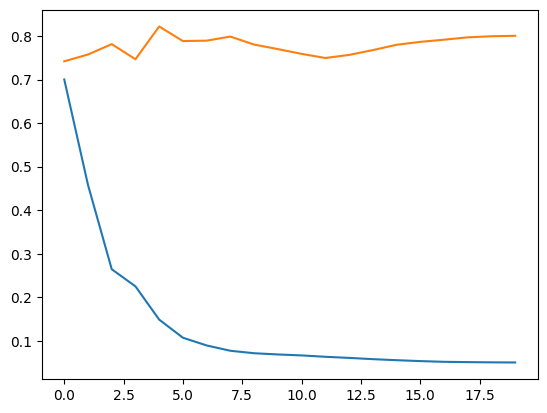

In [60]:
#best values:
n = 5
grid = 4
lamb = 0.001

model = KAN(width=[500, n, 2], grid = grid, k = 3, seed = 2024)
results = model.train(dataset, opt="LBFGS", steps=20, metrics =(train_acc, val_acc),loss_fn=torch.nn.CrossEntropyLoss(), lamb = lamb)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])



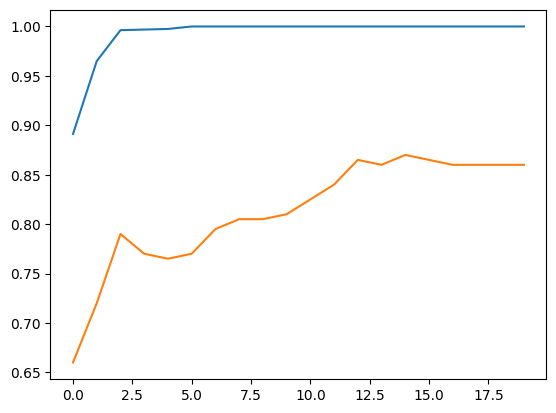

In [61]:
plt.plot(results['train_acc'])
plt.plot(results['val_acc'])

In [67]:
test_pred = predictions(model, dataset['test_input'])
print(extract_results(test_pred, dataset['test_label']))

{'precision': 0.7653061224489796, 'recall': 0.8522727272727273, 'f1_score': 0.8064516129032258, 'auc': 0.8234577922077922, 'confusion_matrix': array([[89, 23],
       [13, 75]], dtype=int64)}


train loss: 1.35e-01 | test loss: 7.44e-01 | reg: 3.96e+01 : 100%|██| 20/20 [24:39<00:00, 73.99s/it]


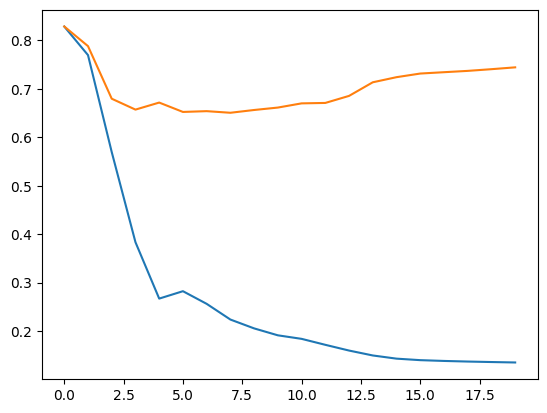

In [6]:
#slightly increasing lambda
n = 5
grid = 4
lamb = 0.005

model = KAN(width=[500, n, 2], grid = grid, k = 3, seed = 2024)
results = model.train(dataset, opt="LBFGS", steps=20, metrics =(train_acc, val_acc),loss_fn=torch.nn.CrossEntropyLoss(), lamb = lamb)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])

[0.5249999761581421, 0.800000011920929, 0.8600000143051147, 0.8199999928474426, 0.8349999785423279, 0.8399999737739563, 0.824999988079071, 0.8399999737739563, 0.8349999785423279, 0.8450000286102295, 0.8550000190734863, 0.8450000286102295, 0.8399999737739563, 0.824999988079071, 0.8299999833106995, 0.8299999833106995, 0.824999988079071, 0.824999988079071, 0.824999988079071, 0.824999988079071]


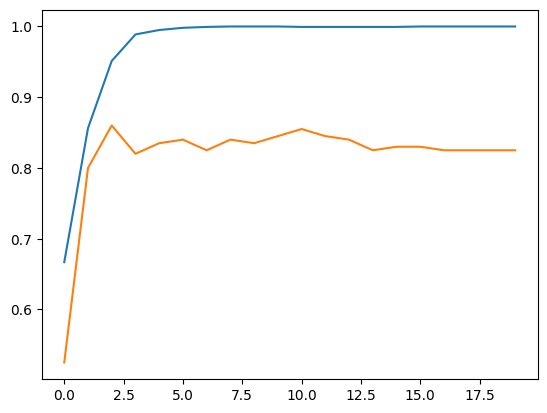

In [7]:
plt.plot(results['train_acc'])
plt.plot(results['val_acc'])

print(results['val_acc'])

In [11]:
test_pred = predictions(model, dataset['test_input'])
print(extract_results(test_pred, dataset['test_label']))

train_pred = predictions(model, dataset['train_input'])
print(extract_results(train_pred, dataset['train_label']))


{'precision': 0.7079646017699115, 'recall': 0.9090909090909091, 'f1_score': 0.7960199004975125, 'auc': 0.8072240259740259, 'confusion_matrix': array([[79, 33],
       [ 8, 80]], dtype=int64)}
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'auc': 1.0, 'confusion_matrix': array([[790,   0],
       [  0, 810]], dtype=int64)}


In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

train loss: 3.44e-02 | test loss: 8.76e-01 | reg: 3.69e+01 : 100%|██| 20/20 [24:50<00:00, 74.54s/it]


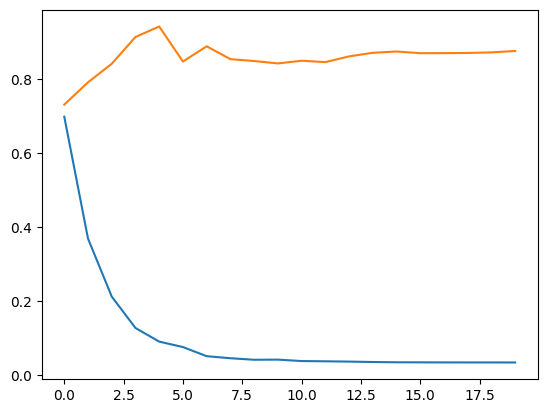

In [71]:
#slightly decreasing increasing lambda
n = 5
grid = 4
lamb = 0.0005

model1 = KAN(width=[500, n, 2], grid = grid, k = 3, seed = 2024)
results1 = model1.train(dataset, opt="LBFGS", steps=20, metrics =(train_acc, val_acc),loss_fn=torch.nn.CrossEntropyLoss(), lamb = lamb)

plt.plot(results1['train_loss'])
plt.plot(results1['test_loss'])



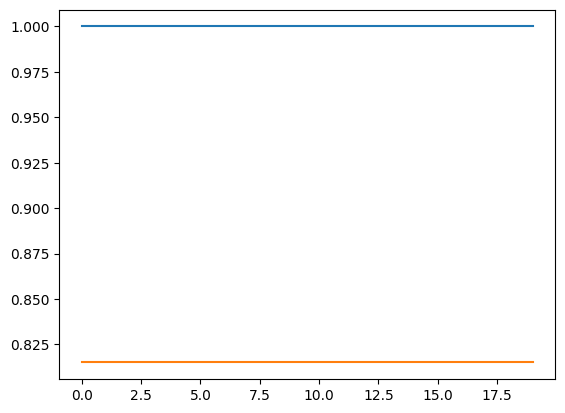

In [72]:
plt.plot(results1['train_acc'])
plt.plot(results1['val_acc'])

In [73]:
test_pred = predictions(model1, dataset['test_input'])
print(extract_results(test_pred, dataset['test_label']))

{'precision': 0.7692307692307693, 'recall': 0.7954545454545454, 'f1_score': 0.7821229050279329, 'auc': 0.8039772727272727, 'confusion_matrix': array([[91, 21],
       [18, 70]], dtype=int64)}


train loss: 3.84e-01 | test loss: 6.48e-01 | reg: 5.96e+01 : 100%|████| 4/4 [04:45<00:00, 71.29s/it]


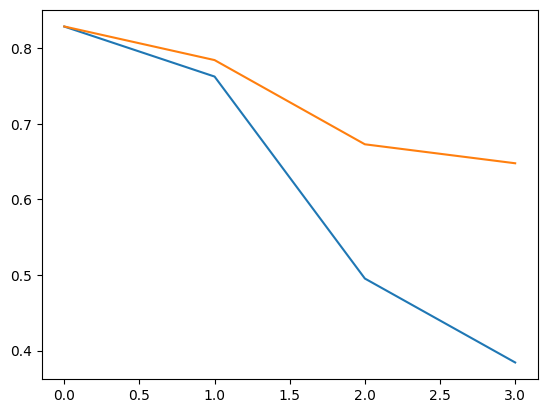

In [76]:
#slightly increasing lambda and interrupting after 4 iterations
n = 5
grid = 4
lamb = 0.005

model = KAN(width=[500, n, 2], grid = grid, k = 3, seed = 2024)
results = model.train(dataset, opt="LBFGS", steps=4, metrics =(train_acc, val_acc),loss_fn=torch.nn.CrossEntropyLoss(), lamb = lamb)

plt.plot(results['train_loss'])
plt.plot(results['test_loss'])

{'precision': 0.8157894736842105, 'recall': 0.7045454545454546, 'f1_score': 0.7560975609756098, 'auc': 0.7897727272727273, 'confusion_matrix': array([[98, 14],
       [26, 62]], dtype=int64)}


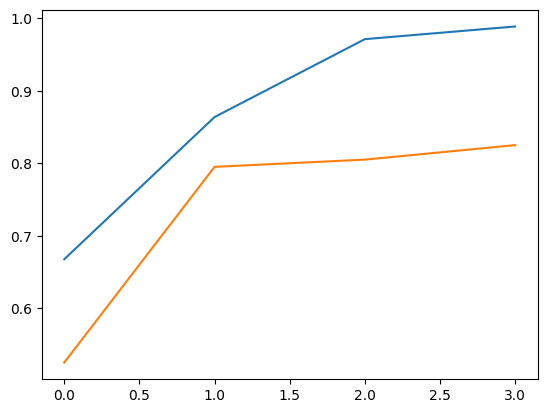

In [78]:
plt.plot(results['train_acc'])
plt.plot(results['val_acc'])

test_pred = predictions(model, dataset['test_input'])
print(extract_results(test_pred, dataset['test_label']))

**best model**\
n = 5 \
grid = 4 \
\lambda = 0.005 \
epochs = 20

***(Per LISA)***

In [ ]:
#Questo non ti serve per tirare fuori le predictions dall'MLP
#def predictions(model, X):
#    return torch.argmax(model(X), dim = 1)

#In teoria dovrebbe funzionare anche con pred e label dell'MLP. 
def extract_results(pred, labels):
    # Ensure the inputs are torch tensors
    pred = torch.tensor(pred) if not isinstance(pred, torch.Tensor) else pred
    labels = torch.tensor(labels) if not isinstance(labels, torch.Tensor) else labels
    
    # Convert tensors to numpy arrays for sklearn functions
    pred_np = pred.numpy()
    labels_np = labels.numpy()
    
    # Calculate precision, recall, and f1 score
    precision = precision_score(labels_np, pred_np)
    recall = recall_score(labels_np, pred_np)
    f1 = f1_score(labels_np, pred_np)
    
    # Calculate AUC
    auc = roc_auc_score(labels_np, pred_np)
    
    # Calculate confusion matrix
    cm = confusion_matrix(labels_np, pred_np)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'confusion_matrix': cm
    }
